# My first autoencoder (using `jax` and `equinox`)

$$ \text{enc}_\theta \colon \mathbb{R}^D \to \mathbb{R}^d $$

$$ \text{dec}_\theta \colon \mathbb{R}^d \to \mathbb{R}^D $$

$$ f_\theta \colon \mathbb{R}^D \to \mathbb{R}^D $$

$$ f_\theta(x) = \text{dec}_\theta(\text{enc}_\theta(x)) $$

$$ \mathcal{L}(\theta) = \|f_\theta(x) - x\|^2 $$

Taken and adapted from [`equinox`'s tutorial on CNNs](https://github.com/patrick-kidger/equinox/blob/main/examples/mnist.ipynb).

In [ ]:
!pip install equinox optax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.0 MB/s eta 0:00:00


## Understanding `jax`

[Taken and adapted from `jax`'s own tutorials.](https://jax.readthedocs.io/en/latest/jax-101/01-jax-basics.html)

Think of `jax` as `numpy` with three main additions:
- **Native autodifferentiation:** you can run your `numpy` operations and ask for a gradient. `grad`
- **Easy vectorization on batches:** you can focus on making your code work on a single element, and batching will be managed easily. `vmap`
- **Hardware Acceleration:** you can compile your code so it runs super fast in CPUs, GPUs and other types of hardware. `jit`

Moreover, `jax` está pensado con *programación funcional* en mente. Los objetos principales son *funciones* (e.g. `grad`)

In [ ]:
import numpy as np

x = np.linspace(0, 1, 100)
np.cos(x)

array([1.        , 0.99994899, 0.99979595, 0.9995409 , 0.99918387,
       0.99872489, 0.99816401, 0.9975013 , 0.9967368 , 0.99587061,
       0.99490282, 0.99383351, 0.9926628 , 0.99139081, 0.99001767,
       0.98854352, 0.98696851, 0.9852928 , 0.98351656, 0.98163997,
       0.97966323, 0.97758653, 0.97541009, 0.97313412, 0.97075887,
       0.96828458, 0.96571149, 0.96303986, 0.96026998, 0.95740213,
       0.95443659, 0.95137367, 0.94821368, 0.94495695, 0.9416038 ,
       0.93815458, 0.93460964, 0.93096935, 0.92723406, 0.92340418,
       0.91948007, 0.91546216, 0.91135084, 0.90714653, 0.90284967,
       0.89846069, 0.89398004, 0.88940818, 0.88474558, 0.8799927 ,
       0.87515004, 0.87021809, 0.86519735, 0.86008833, 0.85489156,
       0.84960756, 0.84423688, 0.83878007, 0.83323767, 0.82761026,
       0.8218984 , 0.81610269, 0.81022371, 0.80426207, 0.79821837,
       0.79209322, 0.78588726, 0.77960112, 0.77323543, 0.76679085,
       0.76026803, 0.75366765, 0.74699036, 0.74023687, 0.73340

### Native autodifferentiation

Consider this example:

In [ ]:
import jax
import jax.numpy as jnp

def f(x: jnp.ndarray) -> jnp.ndarray:
  return jnp.sin(x)

You can easily compute the derivative of a function that manipulates `jnp` arrays using `jax.grad`:

In [ ]:
df_dx = jax.grad(f)

In [ ]:
df_dx

<function __main__.f(x: jax.Array) -> jax.Array>

Now `df_dx` is a **function**, you can evaluate it in a given value:

In [ ]:
df_dx(0.0)

Array(1., dtype=float32, weak_type=True)

In [ ]:
def g(x, y):
  return jnp.sin(2*x + y)

In [ ]:
dg_dx = jax.grad(g, argnums=0) # 2cos(2x + y)
dg_dy = jax.grad(g, argnums=1) # cos(2x + y)

In [ ]:
dg_dx(0.0, 0.0)

Array(2., dtype=float32, weak_type=True)

In [ ]:
dg_dy(0.0, 0.0)

Array(1., dtype=float32, weak_type=True)

However, if we try to evaluate on an array of values, the gradient complains because it only knows how to operate on individual elements:

In [ ]:
x = jnp.linspace(0, 2*np.pi, 100)

In [ ]:
df_dx(x)

TypeError: Gradient only defined for scalar-output functions. Output had shape: (100,).

This is where **easy vectorization** comes.

### Easy vectorization

Once you have a function that works on individual instances (say, an image, a vector, or a scalar value), you can easily evaluate it over a batch using `jax.vmap`:

In [ ]:
vmapped_df_dx = jax.vmap(df_dx)
vmapped_df_dx

<function __main__.f(x: jax.Array) -> jax.Array>

That is, `jax.vmap` returns a **function** (again) that can now be evaluated over " additional array axes", as the documentation says:

In [ ]:
jax.vmap(df_dx)(x)

Array([ 1.        ,  0.9979867 ,  0.9919548 ,  0.9819287 ,  0.9679487 ,
        0.9500711 ,  0.9283679 ,  0.90292656,  0.8738494 ,  0.8412535 ,
        0.80527025,  0.76604444,  0.723734  ,  0.67850935,  0.63055265,
        0.5800569 ,  0.52722543,  0.47227103,  0.41541496,  0.35688624,
        0.29692036,  0.23575889,  0.17364822,  0.11083821,  0.0475819 ,
       -0.01586602, -0.07925004, -0.14231484, -0.20480669, -0.26647386,
       -0.32706794, -0.38634512, -0.44406664, -0.50000006, -0.55392015,
       -0.6056098 , -0.65486085, -0.70147485, -0.7452644 , -0.7860531 ,
       -0.8236766 , -0.85798347, -0.8888355 , -0.9161085 , -0.9396926 ,
       -0.959493  , -0.9754298 , -0.9874389 , -0.99547195, -0.9994965 ,
       -0.9994965 , -0.9954719 , -0.98743886, -0.9754298 , -0.959493  ,
       -0.9396926 , -0.9161084 , -0.88883543, -0.85798335, -0.8236765 ,
       -0.7860531 , -0.7452645 , -0.7014749 , -0.65486073, -0.60560966,
       -0.55392   , -0.4999999 , -0.4440665 , -0.38634497, -0.32

We are dealing mostly with **functions**.

Functional programming <- nada tiene estado.
  - Haskell
  - F#
  - OCAML

OOP.                   <- tienen estados.

### Hardware acceleration

[Check this documentation to learn about `jax.jit`, which compiles code that manipulates `jnp` arrays](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html).

In [ ]:
# f es una función "pura".
f_jitted = jax.jit(jax.vmap(f))

# Warm-up (o evaluar para compilar)
f_jitted(x)

# Medir el tiempo de evaluación
%timeit f_jitted(x)

5.69 µs ± 113 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [ ]:
f_vmapped = jax.vmap(f)

f_vmapped(x)

%timeit f_vmapped(x)

822 µs ± 9.01 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
jax.make_jaxpr(f)(0.0)

{ lambda ; a:f32[]. let b:f32[] = sin a in (b,) }

¿podemos hacerle `jit` a todo? **no**.

En general, solo podremos hacerle `jit` a las **funciones puras**.

In [ ]:
def f_con_condicional(x: jnp.ndarray) -> jnp.ndarray:
  if x > 0:
    return x
  else:
    return -x

In [ ]:
f_con_condicional_jit = jax.jit(f_con_condicional)
f_con_condicional_jit(10.0)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function f_con_condicional at <ipython-input-32-dc92de062ff2>:1 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

A pesar que no le podemos hacer `jit` a todo, podemos compilar muchas de las funciones que usamos en el contexto del Machine Learning (porque siempre estamos e.g. pasándole a una red neuronal inputs del mismo tipo).

# Autoencoders in `equinox`

- `jax` es como un `numpy` con autodiff.
- `equinox` es como un `torch`, pero basado en `jax`.

In [ ]:
import torch
from torch import nn

class AutoencoderTorch(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Lineal(784, 128),
        nn.Tanh(),
        nn.Lineal(128, 2),
    )


In [ ]:
import torch

x = torch.tensor([1.0], requires_grad=True)
l = x ** 2

l.backward()
x.grad

class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super(...)

  def forward(self, x: torch.Tensor):
    ...

# Torch implementa autodiferenciación **y** redes neuronales.

# -----------
import jax
import equinox

def f(x):
  return x ** 2

df_dx = jax.grad(f)

class NeuralNetwork(equinox.Module):
  ...

# jax implementa autodiff., y equinox implementa redes neuronales.

tensor([2.])

In [ ]:
# @title Importing the libraries
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
import equinox as eqx
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax
import pandas as pd
import torch
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping

In [ ]:
digits_and_labels = pd.read_csv("sample_data/mnist_train_small.csv", header=None).values

In [ ]:
#@title Loading up the data
digits_and_labels = pd.read_csv("sample_data/mnist_train_small.csv", header=None).values
labels = digits_and_labels[:, 0]
digits = digits_and_labels[:, 1:] / 255.0

data = digits[np.isin(labels,[1,0,8,7])]
labels_of_data = labels[np.isin(labels,[1,0,8,7])]
print(f"Data shape: {data.shape}")

Data shape: (8243, 784)


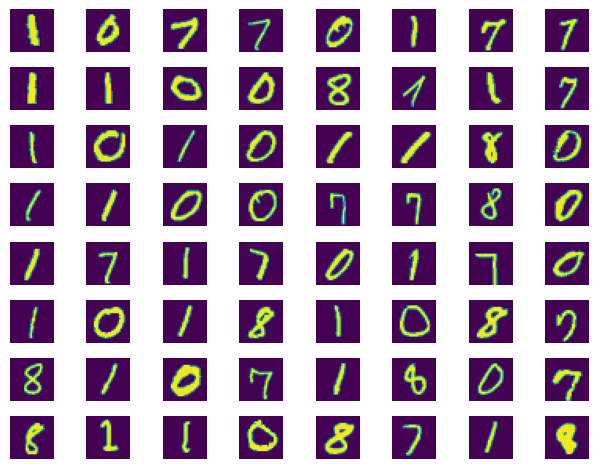

In [ ]:
fig, axes = plt.subplots(8, 8)
for ax in axes.flatten():
  ax.imshow(data[np.random.randint(0, len(data) - 1)].reshape( 28, 28))
  ax.axis("off")

fig.tight_layout()

In [ ]:
#@title Defining hyperparameters
# Hyperparameters
BATCH_SIZE = 256
LEARNING_RATE = 5e-4
STEPS = 5000
PRINT_EVERY = 100
SEED = np.random.randint(0, 1000)

In [ ]:
# @title Building the dataloaders
n_points, input_dim = data.shape

train_index = int(0.8 * n_points)

trainloader = torch.utils.data.DataLoader(
    torch.from_numpy(data[:train_index]), batch_size=BATCH_SIZE, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    torch.from_numpy(data[train_index:]), batch_size=BATCH_SIZE, shuffle=True
)

In [ ]:
# a Jax le gustan las funciones puras.
# f(x) = y, a la misma entrada, misma salida.
import torch

def f(x: torch.Tensor) -> torch.Tensor:
  return x + torch.randint(10, (1,))

def f_pura(x: torch.Tensor, seed: int) -> torch.Tensor:
  torch.manual_seed(seed)
  return x + torch.randint(10, (1,))

In [ ]:
f_pura(torch.tensor([5]), seed=1)

tensor([10])

In [ ]:
# @title Defining the neural network

import equinox as eqx

# La llave aleatoria
key = jax.random.PRNGKey(SEED)

class Autoencoder(eqx.Module):
    encoder_layers: list
    decoder_layers: list

    def __init__(self, key, input_dim: int = 784):
        encoder_key, decoder_key = jax.random.split(key, 2)
        encoder_key1, encoder_key2, encoder_key3, encoder_key4 = jax.random.split(
            encoder_key, 4
        )
        decoder_key1, decoder_key2, decoder_key3, decoder_key4 = jax.random.split(
            decoder_key, 4
        )

        # An MLP encoder
        self.encoder_layers = [
            eqx.nn.Linear(input_dim, 256, key=encoder_key1),
            jax.nn.tanh,
            eqx.nn.Linear(256, 128, key=encoder_key2),
            # jax.nn.tanh,
            # eqx.nn.Linear(256, 128, key=encoder_key3),
            jax.nn.tanh,
            eqx.nn.Linear(128, 2, key=encoder_key4),
        ]

        # An MLP decoder
        self.decoder_layers = [
            eqx.nn.Linear(2, 128, key=decoder_key1),
            jax.nn.tanh,
            eqx.nn.Linear(128, 256, key=decoder_key2),
            # jax.nn.tanh,
            # eqx.nn.Linear(256, 512, key=decoder_key3),
            jax.nn.tanh,
            eqx.nn.Linear(256, input_dim, key=decoder_key4),
        ]

    def encode(self, x: Float[Array, "1 784"]) -> Float[Array, "1 2"]:
        for layer in self.encoder_layers:
            x = layer(x)

        return x

    def decode(self, z: Float[Array, "1 2"]) -> Float[Array, "1 784"]:
        for layer in self.decoder_layers:
            z = layer(z)

        return z

    def __call__(self, x: Float[Array, "1 784"]) -> Float[Array, "1 784"]:
        z = self.encode(x)
        x = self.decode(z)

        return x

Las redes neuronales en `equinox` suelen implementar el **dunder method** `__call__`

In [ ]:
class Ejemplo:
  def __init__(self, offset: int):
    self.offset = offset

  def un_metodo(self, x):
    return x + self.offset - 3

  def __call__(self, x):
    return x + self.offset

In [ ]:
ejemplo_numero_1 = Ejemplo(8)
ejemplo_numero_1.__call__(3) == ejemplo_numero_1(3)

True

In [ ]:
# @title Defining the loss, and compiling it

# Una función de pérdida con el modelo como primera entrada
def loss(model: Autoencoder, batch: Float[Array, "B 784"]) -> Float[Array, "B"]:
    x = batch
    x_hat = jax.vmap(model)(x)
    return jnp.mean((x - x_hat) ** 2)

# Podríamos compilar la función de pérdida usando
# eqx.filter_jit (lo cual es casi lo mismo que
# jax.jit).
loss_compilada = eqx.filter_jit(loss)

# Un ejemplo de entrada (para el warm-up de jit)
dummy_input = jnp.ones((BATCH_SIZE, 784))

# Mi llave aleatoria nueva para la red
key, subkey = jax.random.split(key, 2)
model = Autoencoder(subkey, input_dim=784)

# Compilando el gradiente de la función error
loss_grad = eqx.filter_jit(eqx.filter_grad(loss))

# Evaluando en el ejemplo de la entrada para la compilación
loss_grad(model, dummy_input)
print(loss_grad)

_JitWrapper(
  fn='loss',
  filter_warning=False,
  donate_first=False,
  donate_rest=False
)


In [ ]:
loss = eqx.filter_jit(loss)
loss(model, dummy_input)

Array(1.0388584, dtype=float32)

In [ ]:
# @title Evaluating and training

# Compilar la pérdida promedio en el test set.
def evaluate(
    model: Autoencoder, testloader: torch.utils.data.DataLoader
) -> Float[Array, "1"]:
    avg_loss = 0
    for x in testloader:
        x = x.numpy()
        # Note that all the JAX operations happen
        # inside `loss`, and both have JIT wrappers
        # so this is fast.
        avg_loss += loss(model, x)

    return avg_loss / len(testloader)


print(evaluate(model, testloader))


def train(
    model: Autoencoder,
    trainloader: torch.utils.data.DataLoader,
    testloader: torch.utils.data.DataLoader,
    optim: optax.GradientTransformation,  # puede ser adam, SGD, ...
    steps: int,
    print_every: int,
) -> Autoencoder:
    # Just like earlier: It only makes sense to train the arrays in our model,
    # so filter out everything else.

    # Inicializamos la optimización pasándole a optim (una
    # transformación del gradiente) todos los pesos del modelo.
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    # Always wrap everything -- computing gradients, running the optimiser, updating
    # the model -- into a single JIT region. This ensures things run as fast as
    # possible.
    @eqx.filter_jit
    def make_step(
        model: Autoencoder,
        opt_state: PyTree,
        x: Float[Array, "batch 784"],
    ):
        # grads = loss_grad(model, x)
        # Computamos el gradiente del error, y el valor del error
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, x)

        # Hacemos un paso en la optimización
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)

        return model, opt_state, loss_value

    # Loop over our training dataset as many times as we need.
    def infinite_trainloader():
        while True:
            yield from trainloader

    for step, x in zip(range(steps), infinite_trainloader()):
        # PyTorch dataloaders give PyTorch tensors by default,
        # so convert them to NumPy arrays.
        x = x.numpy()

        # Hacemos un paso en la optimización
        model, opt_state, train_loss = make_step(model, opt_state, x)

        # Cada cierto tiempo, imprimimos un resumen.
        if (step % print_every) == 0 or (step == steps - 1):
            test_loss = evaluate(model, testloader)
            print(
                f"{step=}, train_loss={train_loss.item()}, "
                f"test_loss={test_loss.item()}"
            )

    return model

optim = optax.adamw(LEARNING_RATE)

model = train(model, trainloader, testloader, optim, STEPS, PRINT_EVERY)

0.12638588
step=0, train_loss=0.13066856563091278, test_loss=0.11514346301555634
step=100, train_loss=0.047755688428878784, test_loss=0.04660455137491226
step=200, train_loss=0.042117878794670105, test_loss=0.04191262274980545
step=300, train_loss=0.0362817756831646, test_loss=0.03835221752524376
step=400, train_loss=0.03743952885270119, test_loss=0.036266911774873734
step=500, train_loss=0.03479420021176338, test_loss=0.03501604124903679
step=600, train_loss=0.034956518560647964, test_loss=0.03384434059262276
step=700, train_loss=0.03569943830370903, test_loss=0.03276633098721504
step=800, train_loss=0.03196674585342407, test_loss=0.03237020596861839
step=900, train_loss=0.031905900686979294, test_loss=0.031813789159059525
step=1000, train_loss=0.03093016892671585, test_loss=0.03155606985092163
step=1100, train_loss=0.033490538597106934, test_loss=0.031042397022247314
step=1200, train_loss=0.030733637511730194, test_loss=0.0304852444678545
step=1300, train_loss=0.029088659211993217, t

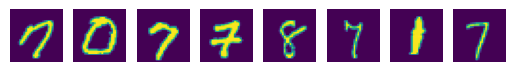

In [ ]:
_, axes = plt.subplots(1, 8)
for ax, image in zip(axes, data):
  ax.imshow(image.reshape(28, 28))
  ax.axis("off")

In [ ]:
z0 = model.encode(data[0])

In [ ]:
reconstruccion = model.decode(z0)

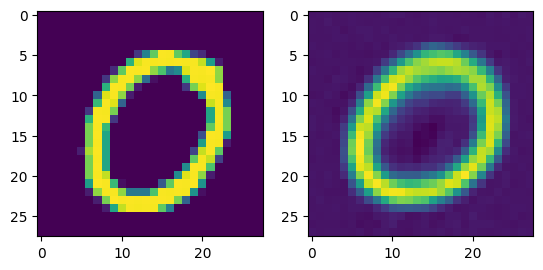

In [ ]:
random_x = data[np.random.randint(0, len(data))]
z0 = model.encode(random_x)
reconstruccion = model.decode(z0)

_, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(random_x.reshape(28, 28))
ax2.imshow(reconstruccion.reshape(28, 28))

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def add_image_at_point(image: np.ndarray, point: np.ndarray, ax: plt.Axes):
  im = OffsetImage(image, zoom=1)
  ab = AnnotationBbox(im, point, xycoords='data', frameon=False)
  ax.add_artist(ab)
  ax.update_datalim([point])
  ax.autoscale()


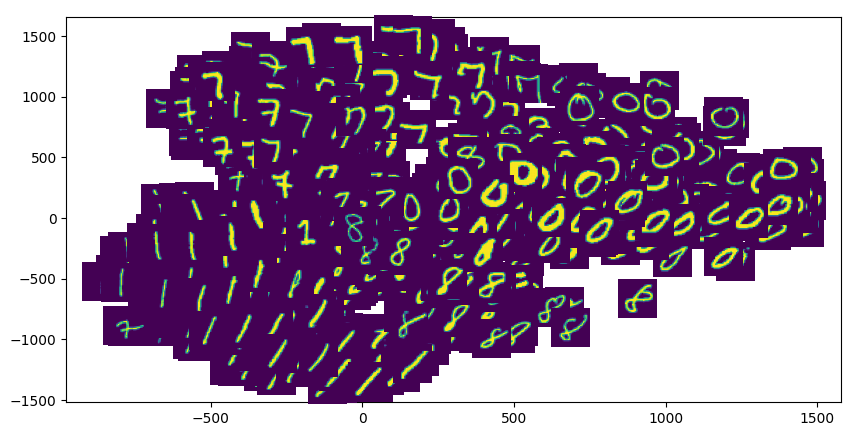

In [ ]:
import matplotlib.pyplot as plt

z = jax.vmap(model.encode)(data)

fig_latent_space, ax = plt.subplots(1, 1, figsize=(10, 5))

for latent_code, image in zip(z[::3], data[::3]):
  add_image_at_point(image.reshape(28, 28), latent_code*100.0, ax)


# ax.scatter(z[:, 0], z[:, 1])

plt.show()

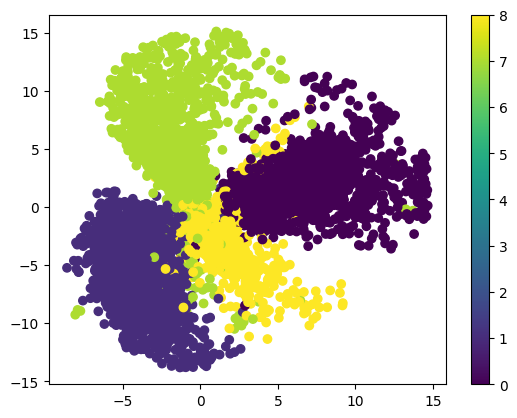

In [ ]:
fig, ax = plt.subplots(1, 1)

plot = ax.scatter(z[:, 0], z[:, 1], c=labels_of_data)
plt.colorbar(plot)